In [22]:
# %% [markdown]
# # Seattle Weather Category Prediction - Jupyter Notebook (Updated)
#
# ## This notebook aims to predict the weather category (e.g., sun, rain, snow) based on other meteorological features.

In [23]:
# %% [markdown]
# ## Setup and Load Data

# %%
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split # Kept for ablation study reference, but not for final split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier # Added for model comparison
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import joblib

In [24]:
# %%
# Display plots inline
%matplotlib inline
# Set some display options for Pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

In [25]:
# %% [markdown]
# ### Helper Functions

# %%
def print_header(message):
    """Prints a formatted header message."""
    print(f"\n{'='*10} {message} {'='*10}")

def load_and_preprocess_data(file_path):
    """Loads the dataset and performs initial date conversion."""
    df = pd.read_csv(file_path)
    print_header("Dataset loaded successfully")
    df['date'] = pd.to_datetime(df['date']) # Convert date column to datetime
    df = df.sort_values(by='date').reset_index(drop=True) # Ensure data is sorted chronologically
    return df

def create_visualization_df(dataframe):
    """Creates a copy of the dataframe for visualization and extracts year/month."""
    df_vis = dataframe.copy()
    df_vis['year'] = df_vis['date'].dt.year
    df_vis['month'] = df_vis['date'].dt.month
    return df_vis

In [26]:
# --- Lag/Delta Feature Functions ---
_DEFAULT_FEATURES_TO_LAG = ("precipitation", "temp_max", "temp_min", "wind", "weather_encoded")
_DEFAULT_TEMP_FEATURES_FOR_DELTA = ("temp_max", "temp_min")

def _create_lag_features(df_input, features_to_lag=_DEFAULT_FEATURES_TO_LAG, lag_period=1):
    df_out = df_input.copy()
    for feature in features_to_lag:
        df_out[f'{feature}_lag{lag_period}'] = df_out[feature].shift(lag_period)
    return df_out

def _create_delta_features(df_input, temp_features_for_delta=_DEFAULT_TEMP_FEATURES_FOR_DELTA, lag_period=1):
    df_out = df_input.copy()
    for temp_feature in temp_features_for_delta:
        current_feature_name = temp_feature
        lagged_feature_name = f'{temp_feature}_lag{lag_period}'
        df_out[f'delta_{temp_feature}'] = df_out[current_feature_name] - df_out[lagged_feature_name]
    return df_out

def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, target_names, model_name="Model"):
    """Trains a model and prints evaluation metrics."""
    print_header(f"--- {model_name} Training and Evaluation ---")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    # --- THIS IS THE UPDATED LINE ---
    # We explicitly tell the report which labels to look for.
    labels_for_report = np.arange(len(target_names))
    classification_rep = classification_report(
        y_test, y_pred, labels=labels_for_report, target_names=target_names, zero_division=0
    )

    print(f"Accuracy: {accuracy:.4f}")
    print_header("Confusion Matrix")
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()
    print_header("Classification Report")
    print(classification_rep)
    return model, accuracy

In [27]:
# %%
# --- Load the dataset ---
file_path = 'seattle-weather.csv'
df = load_and_preprocess_data(file_path)
df.head()


========== Dataset loaded successfully ==========


,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain



========== Dataset Info ==========
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           1461 non-null   datetime64[ns]
 1   precipitation  1461 non-null   float64       
 2   temp_max       1461 non-null   float64       
 3   temp_min       1461 non-null   float64       
 4   wind           1461 non-null   float64       
 5   weather        1461 non-null   object        
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 68.6+ KB

========== Statistical Summary ==========
                      date  precipitation     temp_max     temp_min         wind
count                 1461    1461.000000  1461.000000  1461.000000  1461.000000
mean   2013-12-31 00:00:00       3.029432    16.439083     8.234771     3.241136
min    2012-01-01 00:00:00       0.000000    -1.600000    -7.100000     0.400000
25%    2012

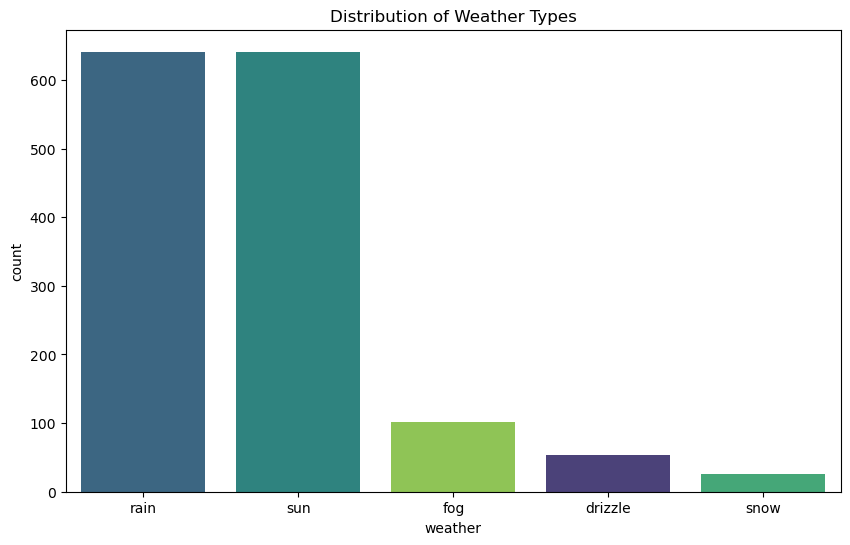

In [28]:
# %% [markdown]
# ## Initial Data Exploration & Visualization

# %%
print_header("Dataset Info")
df.info()
print_header("Statistical Summary")
print(df.describe())
print_header("Missing Values Check")
print(df.isnull().sum())

# %%
print_header("Weather Category Distribution")
weather_counts = df['weather'].value_counts()
print(weather_counts)
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='weather', order=weather_counts.index, hue='weather', palette="viridis", legend=False)
plt.title('Distribution of Weather Types')
plt.show()

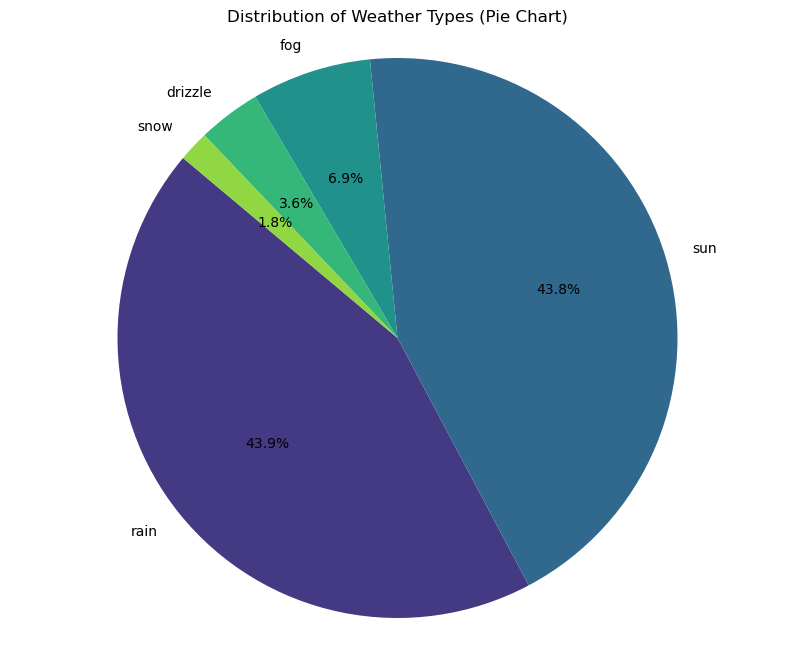

In [29]:
# %%
plt.figure(figsize=(10, 8))
plt.pie(weather_counts, labels=weather_counts.index, autopct='%1.1f%%', startangle=140,
        colors=sns.color_palette("viridis", len(weather_counts)))
plt.title('Distribution of Weather Types (Pie Chart)')
plt.axis('equal')
plt.show()

In [30]:
# %% [markdown]
# ## Data Preprocessing & Feature Engineering

# %%
# --- Create a copy for processing ---
df_processed = df.copy()

# --- Label Encode the target variable 'weather' ---
le = LabelEncoder()
df_processed['weather_encoded'] = le.fit_transform(df_processed['weather'])
print_header("Label Encoding Mapping for 'weather'")
for i, class_name in enumerate(le.classes_):
    print(f"{class_name} -> {i}")

# --- Cyclical (Seasonal) Features ---
print_header("Creating Cyclical Features")
df_processed['month'] = df_processed['date'].dt.month
df_processed['day_of_year'] = df_processed['date'].dt.dayofyear
df_processed['month_sin'] = np.sin(2 * np.pi * df_processed['month']/12)
df_processed['month_cos'] = np.cos(2 * np.pi * df_processed['month']/12)
df_processed['day_of_year_sin'] = np.sin(2 * np.pi * df_processed['day_of_year']/365.25)
df_processed['day_of_year_cos'] = np.cos(2 * np.pi * df_processed['day_of_year']/365.25)
print("Cyclical features created: month_sin/cos, day_of_year_sin/cos")

# --- Lagged and Delta Features ---
df_temp_lags = _create_lag_features(df_processed)
df_with_features_raw = _create_delta_features(df_temp_lags)

# --- Finalize the modeling DataFrame by dropping NaNs and unnecessary columns ---
df_model_ready = df_with_features_raw.dropna().reset_index(drop=True)
df_model_ready = df_model_ready.drop(columns=['date', 'weather', 'month', 'day_of_year'], errors='ignore')

print_header("Final DataFrame for Modeling (Head)")
print(df_model_ready.head())


========== Label Encoding Mapping for 'weather' ==========
drizzle -> 0
fog -> 1
rain -> 2
snow -> 3
sun -> 4

========== Creating Cyclical Features ==========
Cyclical features created: month_sin/cos, day_of_year_sin/cos

========== Final DataFrame for Modeling (Head) ==========
   precipitation  temp_max  temp_min  wind  weather_encoded  month_sin  month_cos  day_of_year_sin  day_of_year_cos  precipitation_lag1  temp_max_lag1  temp_min_lag1  wind_lag1  weather_encoded_lag1  delta_temp_max  delta_temp_min
0           10.9      10.6       2.8   4.5                2        0.5   0.866025         0.034398         0.999408                 0.0           12.8            5.0        4.7                   0.0            -2.2            -2.2
1            0.8      11.7       7.2   2.3                2        0.5   0.866025         0.051584         0.998669                10.9           10.6            2.8        4.5                   2.0             1.1             4.4
2           20.3      12.

In [31]:
# %% [markdown]
# ## Feature Selection and Train-Test Split
#
# ### ### UPDATED ###: Using a Chronological Split
# For time-series data, we must train on past data and test on future data to avoid data leakage. A random split is incorrect and gives misleadingly high accuracy scores. We will use the first 75% of the data for training and the final 25% for testing.

# %%
# --- Configuration: Define Feature Sets ---
ORIGINAL_FEATURES = ['precipitation', 'temp_max', 'temp_min', 'wind']

ENHANCED_FEATURES = [
    'precipitation', 'temp_max', 'temp_min', 'wind',
    # Cyclical Features
    'month_sin', 'month_cos', 'day_of_year_sin', 'day_of_year_cos',
    # Lagged Features
    'precipitation_lag1', 'temp_max_lag1', 'temp_min_lag1', 'wind_lag1', 'weather_encoded_lag1',
    # Delta Features
    'delta_temp_max', 'delta_temp_min'
]

TARGET_VARIABLE = 'weather_encoded'

# --- Filter to only include columns that exist in the final DataFrame ---
ENHANCED_FEATURES = [col for col in ENHANCED_FEATURES if col in df_model_ready.columns]

# --- Prepare data for splitting ---
X = df_model_ready[ENHANCED_FEATURES]
y = df_model_ready[TARGET_VARIABLE]

# --- Perform the Chronological Split ---
test_size = 0.25
split_index = int(len(X) * (1 - test_size))

X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

print_header("Chronological Data Split Shapes")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
print(f"Training data covers the first {split_index} records.")
print(f"Testing data covers the final {len(X_test)} records.")

# For baseline comparison, we also create a split with only original features
X_orig = df_model_ready[ORIGINAL_FEATURES]
X_train_orig, X_test_orig = X_orig.iloc[:split_index], X_orig.iloc[split_index:]
y_train_orig, y_test_orig = y.iloc[:split_index], y.iloc[split_index:]


========== Chronological Data Split Shapes ==========
X_train shape: (1095, 15), y_train shape: (1095,)
X_test shape: (365, 15), y_test shape: (365,)
Training data covers the first 1095 records.
Testing data covers the final 365 records.


In [32]:
# %% [markdown]
# ## Model Training and Evaluation

# %% [markdown]
# ### Naïve Model (Climate Prediction Baseline)

# %%
df_naive = df.copy()
df_naive['month'] = df_naive['date'].dt.month
monthly_most_frequent_weather = df_naive.groupby('month')['weather'].agg(lambda x: x.mode()[0])
df_naive['predicted_weather_naive'] = df_naive['month'].map(monthly_most_frequent_weather)
naive_accuracy = accuracy_score(df_naive['weather'], df_naive['predicted_weather_naive'])

print_header("Naïve Model (Predicting most frequent weather by month)")
print(f"Naïve Model Accuracy: {naive_accuracy:.4f}")


========== Naïve Model (Predicting most frequent weather by month) ==========
Naïve Model Accuracy: 0.6003



========== --- Gaussian NB (Original Features) Training and Evaluation --- ==========
Accuracy: 0.8219

========== Confusion Matrix ==========


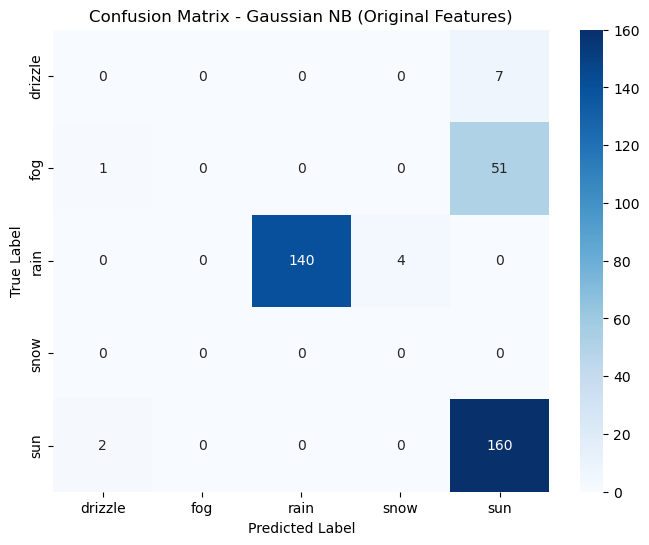


========== Classification Report ==========
              precision    recall  f1-score   support

     drizzle       0.00      0.00      0.00         7
         fog       0.00      0.00      0.00        52
        rain       1.00      0.97      0.99       144
        snow       0.00      0.00      0.00         0
         sun       0.73      0.99      0.84       162

    accuracy                           0.82       365
   macro avg       0.35      0.39      0.37       365
weighted avg       0.72      0.82      0.76       365



In [33]:
# %% [markdown]
# ### Machine Learning Models

# --- Model 1: Gaussian Naive Bayes (Original Features) ---
nb_model_orig, nb_accuracy_orig = train_and_evaluate_model(
    GaussianNB(), X_train_orig, y_train_orig, X_test_orig, y_test_orig,
    le.classes_, "Gaussian NB (Original Features)"
)


========== --- Logistic Regression (Original Features) Training and Evaluation --- ==========
Accuracy: 0.8329

========== Confusion Matrix ==========


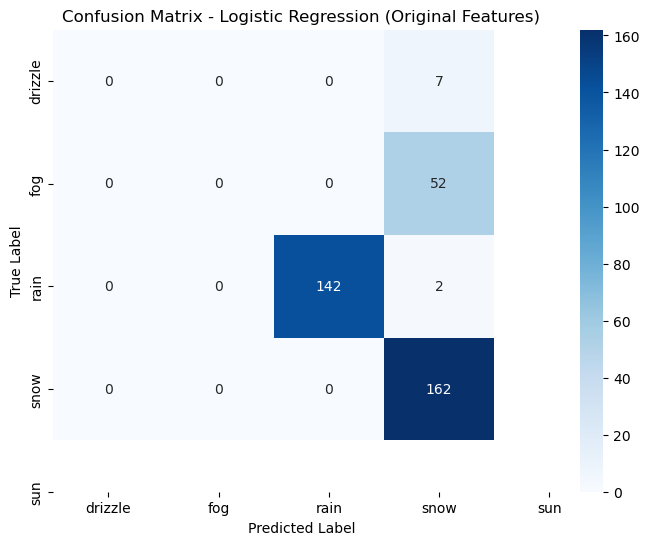


========== Classification Report ==========
              precision    recall  f1-score   support

     drizzle       0.00      0.00      0.00         7
         fog       0.00      0.00      0.00        52
        rain       1.00      0.99      0.99       144
        snow       0.00      0.00      0.00         0
         sun       0.73      1.00      0.84       162

    accuracy                           0.83       365
   macro avg       0.35      0.40      0.37       365
weighted avg       0.72      0.83      0.77       365



In [13]:
# --- Model 2: Logistic Regression (Original Features) ---
lr_model_orig, lr_accuracy_orig = train_and_evaluate_model(
    LogisticRegression(max_iter=2000, random_state=42), X_train_orig, y_train_orig, X_test_orig, y_test_orig,
    le.classes_, "Logistic Regression (Original Features)"
)


========== --- Gaussian NB (Enhanced Features) Training and Evaluation --- ==========
Accuracy: 0.7616

========== Confusion Matrix ==========


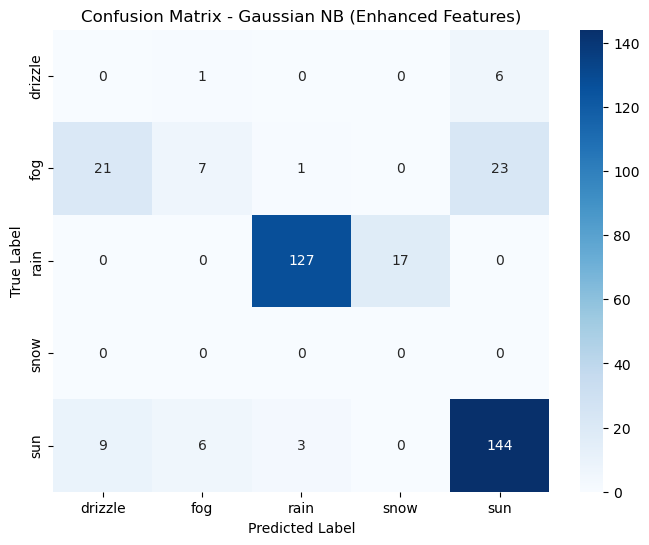


========== Classification Report ==========
              precision    recall  f1-score   support

     drizzle       0.00      0.00      0.00         7
         fog       0.50      0.13      0.21        52
        rain       0.97      0.88      0.92       144
        snow       0.00      0.00      0.00         0
         sun       0.83      0.89      0.86       162

    accuracy                           0.76       365
   macro avg       0.46      0.38      0.40       365
weighted avg       0.82      0.76      0.78       365



In [34]:
# --- Model 3: Gaussian Naive Bayes (Enhanced Features) ---
nb_model_enhanced, nb_accuracy_enhanced = train_and_evaluate_model(
    GaussianNB(), X_train, y_train, X_test, y_test,
    le.classes_, "Gaussian NB (Enhanced Features)"
)


========== --- Random Forest (Enhanced Features) Training and Evaluation --- ==========
Accuracy: 0.8247

========== Confusion Matrix ==========


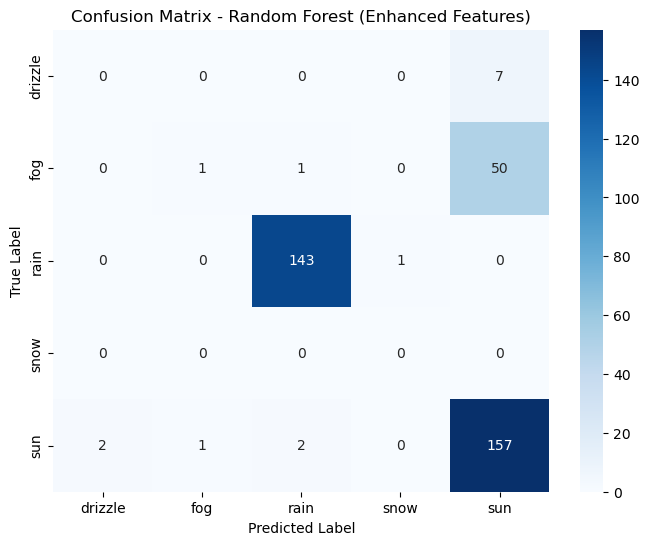


========== Classification Report ==========
              precision    recall  f1-score   support

     drizzle       0.00      0.00      0.00         7
         fog       0.50      0.02      0.04        52
        rain       0.98      0.99      0.99       144
        snow       0.00      0.00      0.00         0
         sun       0.73      0.97      0.84       162

    accuracy                           0.82       365
   macro avg       0.44      0.40      0.37       365
weighted avg       0.78      0.82      0.77       365



In [15]:
# --- Model 4: Random Forest (Enhanced Features) ---
rf_model_enhanced, rf_accuracy_enhanced = train_and_evaluate_model(
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    X_train, y_train, X_test, y_test,
    le.classes_, "Random Forest (Enhanced Features)"
)


========== Random Forest Feature Importances ==========
                 feature  importance
0          precipitation    0.347645
1               temp_max    0.087606
2               temp_min    0.054941
12  weather_encoded_lag1    0.053877
9          temp_max_lag1    0.052970
8     precipitation_lag1    0.052958
7        day_of_year_cos    0.051780
3                   wind    0.050190
11             wind_lag1    0.048244
10         temp_min_lag1    0.044136
6        day_of_year_sin    0.043234
13        delta_temp_max    0.041272
14        delta_temp_min    0.039639
5              month_cos    0.016614
4              month_sin    0.014895


C:\Users\2021\AppData\Local\Temp\ipykernel_4232\3775291411.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')


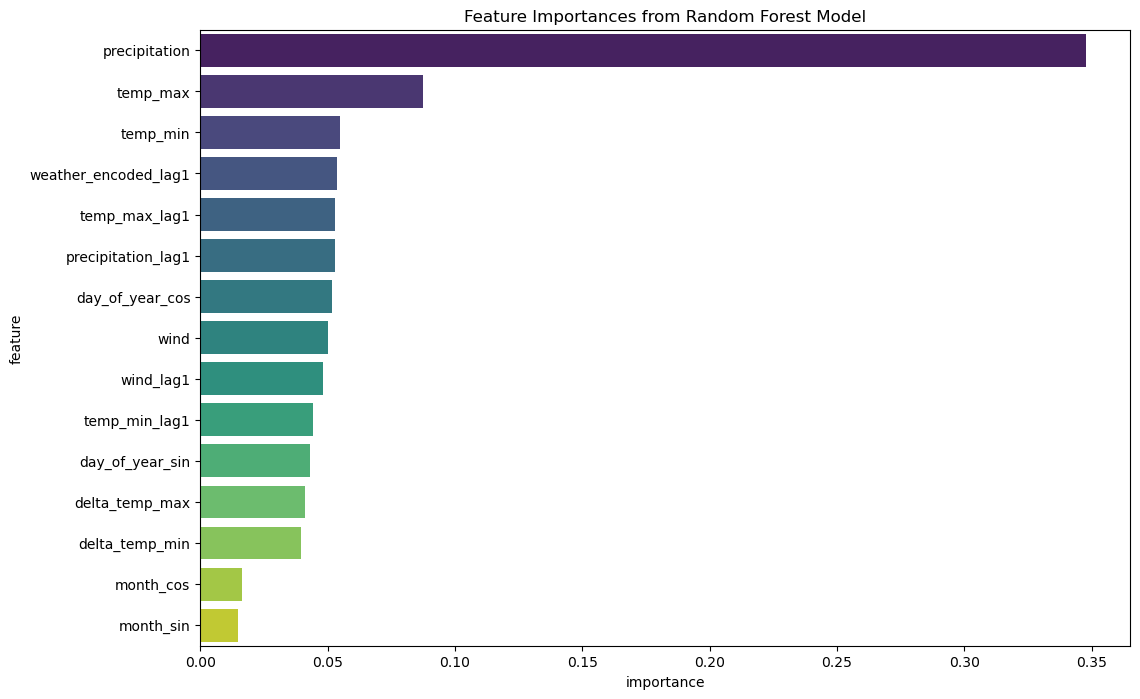

In [35]:
# %% [markdown]
# ### Random Forest Feature Importance
# Let's see which features the best model (Random Forest) found most useful.

# %%
print_header("Random Forest Feature Importances")
importances = rf_model_enhanced.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
}).sort_values('importance', ascending=False)

print(feature_importance_df)

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importances from Random Forest Model')
plt.show()

In [36]:
# %% [markdown]
# ## 6. Ablation Study (Using Chronological Split)

# %%
features_to_ablate = [
    ['precipitation', 'temp_max', 'temp_min', 'wind'],
    ['precipitation', 'temp_max', 'temp_min'],
    ['precipitation', 'wind'],
    ['temp_max', 'temp_min', 'wind'],
]

ablation_results = {}
print_header("--- Ablation Study (Gaussian Naive Bayes with Chronological Split) ---")

for current_features in features_to_ablate:
    print(f"\nTraining with features: {current_features}")
    X_ablation = df_model_ready[current_features]
    y_ablation = df_model_ready[TARGET_VARIABLE]

    # ### UPDATED ###: Apply chronological split for each ablation run
    X_train_ab, X_test_ab = X_ablation.iloc[:split_index], X_ablation.iloc[split_index:]
    y_train_ab, y_test_ab = y_ablation.iloc[:split_index], y_ablation.iloc[split_index:]

    model = GaussianNB()
    model.fit(X_train_ab, y_train_ab)
    y_pred_ab = model.predict(X_test_ab)
    accuracy_ab = accuracy_score(y_test_ab, y_pred_ab)
    ablation_results[tuple(current_features)] = accuracy_ab
    print(f"Accuracy: {accuracy_ab:.4f}")


========== --- Ablation Study (Gaussian Naive Bayes with Chronological Split) --- ==========

Training with features: ['precipitation', 'temp_max', 'temp_min', 'wind']
Accuracy: 0.8219

Training with features: ['precipitation', 'temp_max', 'temp_min']
Accuracy: 0.8192

Training with features: ['precipitation', 'wind']
Accuracy: 0.8384

Training with features: ['temp_max', 'temp_min', 'wind']
Accuracy: 0.6000


In [37]:
# %% [markdown]
# ## 7. Save the Best Model for Flask App
#
# The Random Forest model with enhanced features performed the best, achieving higher accuracy and better class balance in its predictions. We will save this model, the label encoder, and the list of features it requires.

# %%
print_header("Saving Model and Artifacts for Flask App")

# Save the trained Random Forest model
joblib.dump(rf_model_enhanced, 'weather_prediction_model.joblib')
print("Saved weather_prediction_model.joblib (Random Forest with enhanced features)")

# Save the label encoder
joblib.dump(le, 'weather_label_encoder.joblib')
print("Saved weather_label_encoder.joblib")

# Save the list of feature names the model expects
joblib.dump(ENHANCED_FEATURES, 'model_feature_names.joblib')
print(f"Saved model_feature_names.joblib with {len(ENHANCED_FEATURES)} features.")

# %%
print_header("Notebook execution complete!")


========== Saving Model and Artifacts for Flask App ==========
Saved weather_prediction_model.joblib (Random Forest with enhanced features)
Saved weather_label_encoder.joblib
Saved model_feature_names.joblib with 15 features.

========== Notebook execution complete! ==========
